In [1]:
library(tidyverse)
library(caret)
library(MASS)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
DatasetPath <- "./train.csv"
mysubset <- read.csv(DatasetPath)

In [3]:
# shrink dataset
shrink <- function (dataset, shrinkRatio) {
    count <- nrow(dataset); shrinkIndex <- sample(count, count * shrinkRatio)
    shrinkDataset <- dataset[shrinkIndex,]
    shrinkDataset
}

In [8]:
# split into training and holdout dataset
splitDataset <- function (dataset, holdoutRatio) {
    count <- nrow(dataset); trainingIndex <- sample(count, count * (1 - holdoutRatio))
    list(training = shrinkDataset[trainingIndex,], holdout = shrinkDataset[-trainingIndex,])
}

In [5]:
shrinkDataset <- shrink(mysubset, 0.1)

In [9]:
workingDataset <- splitDataset(shrinkDataset, 0.2)

In [11]:
augmentRightTurn <- function(dataset) {
    isRightTurn <- function(entry, exit) {
        rightexit <- list(
            N = c("NW", "W", "SW"),
            NW = c("W", "SW", "S"),
            W = c("SW", "S", "SE"),
            SW = c("S", "SE", "E"),
            S = c("SE", "E", "NE"),
            SE = c("E", "NE", "N"),
            E = c("NE", "N", "NW"),
            NE = c("N", "NW", "W")
        )
        exit %in% rightexit[[entry]]
    }
    vIsRightTurn <- Vectorize(isRightTurn)
    dataset %>% 
        mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(RightTurnAllowed = max(RightTurn)) %>%
        inner_join(dataset)
}

In [13]:
augmented <- augmentRightTurn(workingDataset$training)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



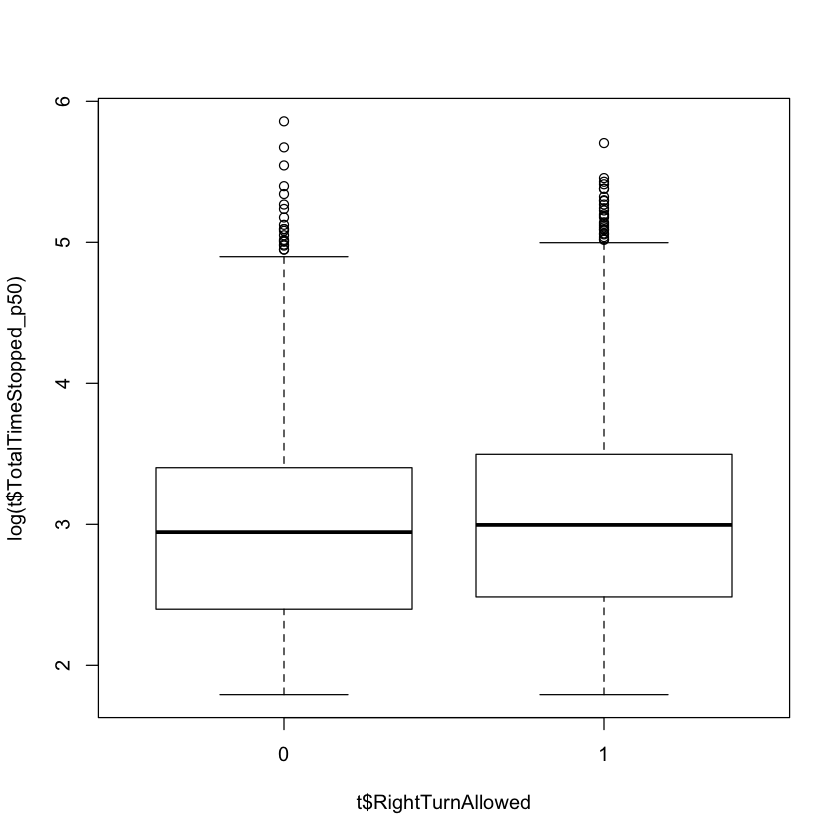

In [14]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$RightTurnAllowed)

In [15]:
augmentLeftTurn <- function(dataset) {
    isLeftTurn <- function(entry, exit) {
        leftexit <- list(
            N = c("NE", "E", "SE"),
            NW = c("N", "NE", "E"),
            W = c("NW", "N", "NE"),
            SW = c("W", "NW", "N"),
            S = c("SW", "W", "NW"),
            SE = c("S", "SW", "W"),
            E = c("SE", "S", "SW"),
            NE = c("E", "SE", "S")
        )
        exit %in% leftexit[[entry]]
    }
    vIsLeftTurn <- Vectorize(isLeftTurn)
    dataset %>% 
        mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(LeftTurnAllowed = max(LeftTurn)) %>%
        inner_join(dataset)
}

In [16]:
augmented <- augmentLeftTurn(augmented)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



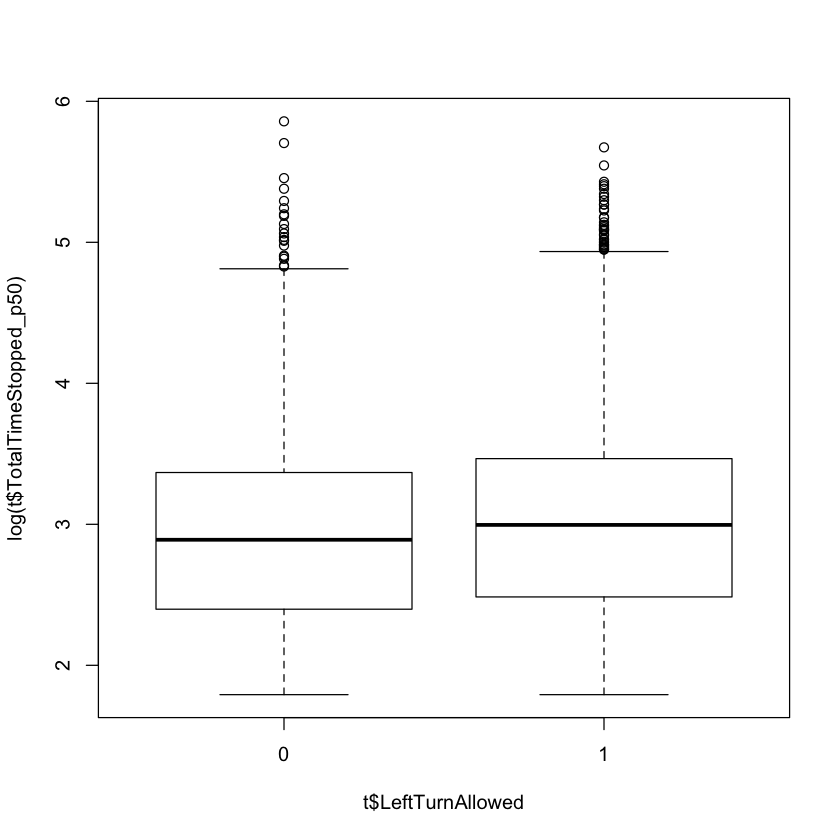

In [17]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$LeftTurnAllowed)

In [18]:
augmented <- augmented %>% mutate(straightThrough = EntryHeading == ExitHeading)

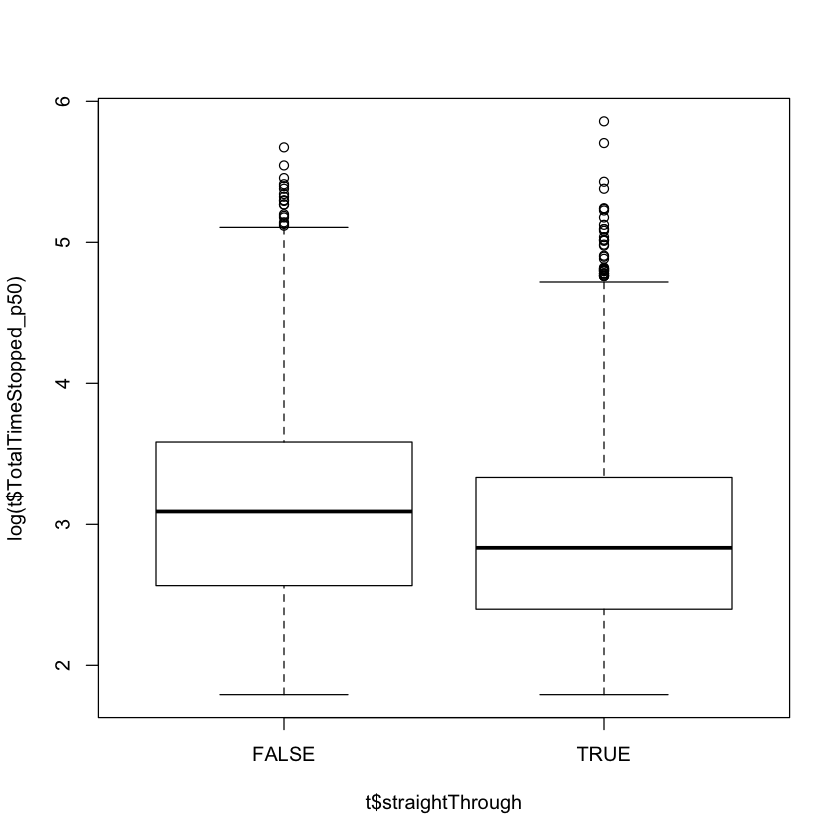

In [19]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$straightThrough)

In [20]:
colnames(augmented)

[1] "IntersectionId"          "EntryHeading"           
 [3] "LeftTurnAllowed"         "RightTurnAllowed"       
 [5] "RowId"                   "Latitude"               
 [7] "Longitude"               "EntryStreetName"        
 [9] "ExitStreetName"          "ExitHeading"            
[11] "Hour"                    "Weekend"                
[13] "Month"                   "Path"                   
[15] "TotalTimeStopped_p20"    "TotalTimeStopped_p40"   
[17] "TotalTimeStopped_p50"    "TotalTimeStopped_p60"   
[19] "TotalTimeStopped_p80"    "TimeFromFirstStop_p20"  
[21] "TimeFromFirstStop_p40"   "TimeFromFirstStop_p50"  
[23] "TimeFromFirstStop_p60"   "TimeFromFirstStop_p80"  
[25] "DistanceToFirstStop_p20" "DistanceToFirstStop_p40"
[27] "DistanceToFirstStop_p50" "DistanceToFirstStop_p60"
[29] "DistanceToFirstStop_p80" "City"                   
[31] "straightThrough"

In [21]:
augmented <- augmented %>% mutate(waitRequired = TotalTimeStopped_p50 > 0)

In [22]:
m <- qda(waitRequired ~ City + LeftTurnAllowed + RightTurnAllowed + straightThrough + Hour + Weekend + Month, data = augmented)

In [23]:
workingDataset$holdout <- workingDataset$holdout %>% mutate(waitRequired = TotalTimeStopped_p50 > 0)
workingDataset$holdout <- augmentRightTurn(workingDataset$holdout)
workingDataset$holdout <- augmentLeftTurn(workingDataset$holdout)
workingDataset$holdout <- workingDataset$holdout %>% mutate(straightThrough = EntryHeading == ExitHeading)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



In [24]:
p <- predict(m, workingDataset$holdout)

In [25]:
a <- table(predictions = p$posterior[,1] < 0.5, truevalue = workingDataset$holdout$waitRequired)
a
a[1, 2] + a[2, 1]

           truevalue
predictions FALSE  TRUE
      FALSE 10564  4277
      TRUE   1097  1190

[1] 5374

In [26]:
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [27]:
workingDataset$holdout$waitRequired <- as.numeric(workingDataset$holdout$waitRequired)
workingDataset$holdout$waitRequired

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0
   [37] 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1
   [73] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0
  [109] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1
  [145] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1
  [181] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  [217] 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0
  [253] 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1
  [289] 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0
  [325] 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1
  [361] 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0
  [397] 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0
  [433] 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0
  [469] 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0
  [505] 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0
  [541] 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1
  [577] 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1
  [613] 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0
  [649] 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  [685] 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1
  [721] 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [757] 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0
  [793] 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0
  [829] 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0
  [865] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1
  [901] 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1
  [937] 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
  [973] 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1
 [1009] 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0
 [1045] 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1
 [1081] 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0
 [1117] 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1
 [1153] 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1
 [1189] 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 [1225] 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 [1261] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 [1297] 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1
 [1333] 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1
 [1369] 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0
 [1405] 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1
 [1441] 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1
 [1477] 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 [1513] 1 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 [1549] 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 [1585] 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1
 [1621] 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 [1657] 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0
 [1693] 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0
 [1729] 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1
 [1765] 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0
 [18

In [30]:
r <- roc(workingDataset$holdout$waitRequired, p$posterior[,1])

Setting levels: control = 0, case = 1

Setting direction: controls > cases



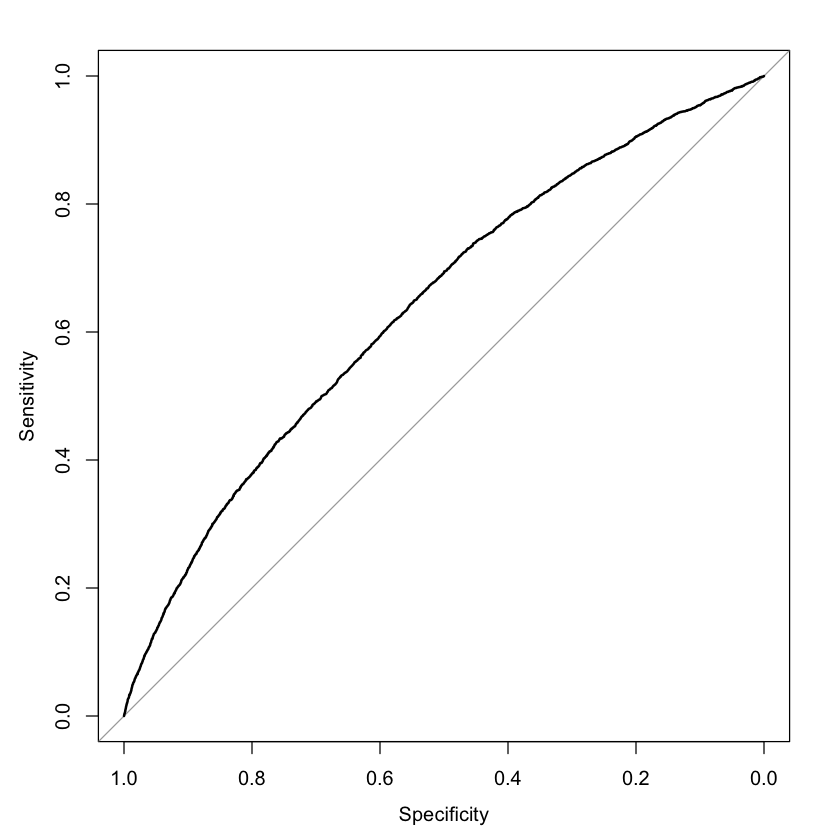

In [31]:
plot(r)

In [32]:
# filter our for wait time greater than 1
greaterThanZero <- augmented %>% filter(TimeFromFirstStop_p50 > 0)

In [33]:
f <- TotalTimeStopped_p50 ~ EntryStreetName + ExitStreetName + City + LeftTurnAllowed + RightTurnAllowed + straightThrough + Hour + Weekend + Month

In [34]:
greaterThanZero$TotalTimeStopped_p50 = log(greaterThanZero$TotalTimeStopped_p50)

In [35]:
lmobj <- lm(f, greaterThanZero)

In [36]:
summary(lmobj)


Call:
lm(formula = f, data = greaterThanZero)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.94252 -0.40937  0.00026  0.40283  2.62900 

Coefficients: (146 not defined because of singularities)
                                                              Estimate
(Intercept)                                                  3.393e+00
EntryStreetName10th Street Northeast                        -3.559e-01
EntryStreetName10th Street Northwest                        -5.803e-02
EntryStreetName14th Street Northeast                        -1.153e-01
EntryStreetName14th Street Northwest                        -4.782e-02
EntryStreetName15th Street Northeast                        -2.390e-01
EntryStreetName16th Street Northeast                        -4.705e-01
EntryStreetName16th Street Northwest                        -8.074e-01
EntryStreetName17th Street Northwest                        -3.345e-01
EntryStreetName17th Street NW                               -5.443e-01
EntryStree

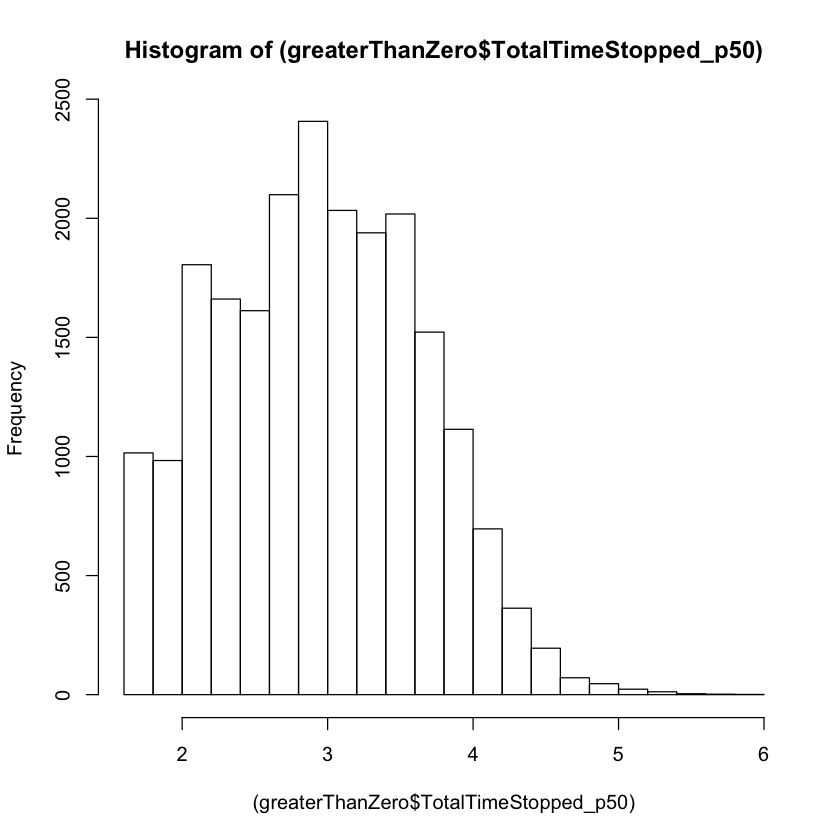

In [37]:
hist((greaterThanZero$TotalTimeStopped_p50))

In [38]:
# going back to the holdout set...

In [39]:
# lets select all those that are predicted to have greater than zero median time

In [51]:
holdoutGreaterThanZero <- workingDataset$holdout %>% filter(waitRequired == 1)

In [56]:
holdoutGreaterThanZero <- 
    holdoutGreaterThanZero %>% filter(
        EntryStreetName %in% workingDataset$training$EntryStreetName)

In [57]:
holdoutGreaterThanZero <- 
    holdoutGreaterThanZero %>% filter(
        ExitStreetName %in% workingDataset$training$ExitStreetName)

In [59]:
holdoutGreaterThanZero$ExitStreetName <- droplevels(holdoutGreaterThanZero$ExitStreetName)

In [60]:
holdoutGreaterThanZero$EntryStreetName <- droplevels(holdoutGreaterThanZero$EntryStreetName)

In [61]:

predict(lmobj, holdoutGreaterThanZero)

ERROR: Error in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels): factor EntryStreetName has new levels Cedar Street, Dalton Street, Franklin Hill Avenue, G Street, Hemenway Street, Jewish War Veterans Drive, Moores Mill Road, Mount Hope Street, North 60th Street, North Orleans Street, North Racine Avenue, North River Road, Norwell Street, Pier Four Boulevard, Pond Street, Short Street, South 37th Street, South Indiana Avenue, South Wolcott Avenue, South Wood Street, Traveler Street, West 115th Street, West 41st Street, West Lake Street, West Service Drive, West Wilson Avenue, Zinkoff Boulevard
